In [1]:
%load_ext autoreload
%autoreload 2

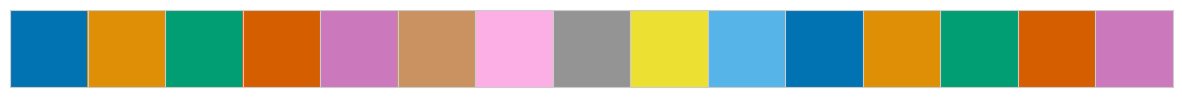

In [2]:
import sys
sys.path.insert(0, '..//')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

from pathlib import Path
import geopandas as gpd
from src.common import schema, enums, functions


sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
fig_format = "pdf"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

In [3]:
path_unassigned_epcs = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\data\unassigned_EPCs")
path_results = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\data\Results_by_LAs")
path_full_results = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\data")


path_validation = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\data\validation data')

path_map =  Path(r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\GIS map and data\UK_2011_LSOA_Heat_Map.geojson")
path_map_scotland = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\data\maps\Scotland_map.geojson")

In [20]:
def extract_dwelling_category(col_name:str, list_dwelling_categories:list[str]):
  dwel_cat = [dwel_cat for dwel_cat in list_dwelling_categories if f" {dwel_cat}" in col_name]
  return dwel_cat[0]

def create_tidy_df(dataf:pd.DataFrame)->pd.DataFrame:

  cols_to_extract = []
  dwel_categories = [x for x in functions.get_list_dwelling_categories() if enums.heating_systems.UNCATEGORIZED.value not in x]
  for dwel_cat in dwel_categories:
    temp_col = f"Average heat demand before energy efficiency measures for {dwel_cat} (kWh)"
    cols_to_extract.append(temp_col)

  temp_df = dataf[cols_to_extract].copy()
  temp_df = temp_df.stack().to_frame().reset_index()

  temp_df[schema.skeletonSchema.dwelling_category] = temp_df['level_1'].apply(lambda x: extract_dwelling_category(x, dwel_categories))
  temp_df.rename(columns={0: "Average annual heat demand before energy efficiency measures (kWh)"},inplace=True)
  return temp_df

In [5]:
full_results_df = pd.read_csv(path_full_results/"full_scotland_results.csv", index_col=0)

## Validation

In [6]:
# Calculate total heating from gas boilers
year = 2011
heating_demand_from_gas_cols = [x for x in full_results_df.columns if enums.heating_systems.GASBOILER.value in x and "Total heat demand before energy efficiency measures of" in x and f"{year}" in x]
full_results_df[f"Total heat demand before energy efficiency measures from gas boilers {year} (GWh)"] = full_results_df[heating_demand_from_gas_cols].sum(axis=1)/1000000

In [7]:
heating_demand_from_gas_cols

['Total heat demand before energy efficiency measures of semi-detached gas boiler in 2011 (kWh)',
 'Total heat demand before energy efficiency measures of terraced gas boiler in 2011 (kWh)',
 'Total heat demand before energy efficiency measures of detached gas boiler in 2011 (kWh)',
 'Total heat demand before energy efficiency measures of flat gas boiler in 2011 (kWh)']

In [8]:
ktoe_to_GWh = 11.6300000000 #1 kilo tons of oil equivalent = 11.6300000000 gigawatt hours
filename = "subnational_total_final_energy_consumption_2020.xlsx"
sub_national_df = pd.read_excel(path_validation/filename, sheet_name=f'{year}', header=6)
sub_national_df = sub_national_df.loc[sub_national_df["Country or region"] == "Scotland"]
sub_national_df = sub_national_df[['Local authority', 'Gas:\nDomestic']].copy()
sub_national_df['Gas:\nDomestic'] = sub_national_df['Gas:\nDomestic']*ktoe_to_GWh*0.975
sub_national_df.rename(columns={'Gas:\nDomestic':'Sub-national gas demand for heating from residential sector (GWh)'}, inplace=True)

sub_national_df = functions.standardise_str(sub_national_df, 'Local authority')
sub_national_df.head()

,Local authority,Sub-national gas demand for heating from residential sector (GWh)
17,all local authorities,28234.542999
355,clackmannanshire,312.672202
356,dumfries and galloway,613.116838
357,east ayrshire,771.743794
358,east lothian,532.261248


In [9]:
cols_from_full_results = [schema.geoLookupSchema.ladnm, f"Total heat demand before energy efficiency measures from gas boilers {year} (GWh)"]
avg_gas_boiler_eff = 0.84
la_full_results = (full_results_df[cols_from_full_results].groupby(schema.geoLookupSchema.ladnm).agg({f"Total heat demand before energy efficiency measures from gas boilers {year} (GWh)":"sum"})/avg_gas_boiler_eff).reset_index()
gas_validation_df = sub_national_df.merge(la_full_results, left_on="Local authority", right_on=schema.geoLookupSchema.ladnm, how="left")
gas_validation_df = gas_validation_df.drop('ladnm', axis=1).dropna().set_index('Local authority')
gas_validation_df.index = [x.title() for x in gas_validation_df.index]

Text(0, 0.5, 'Gas demand (GWh)')

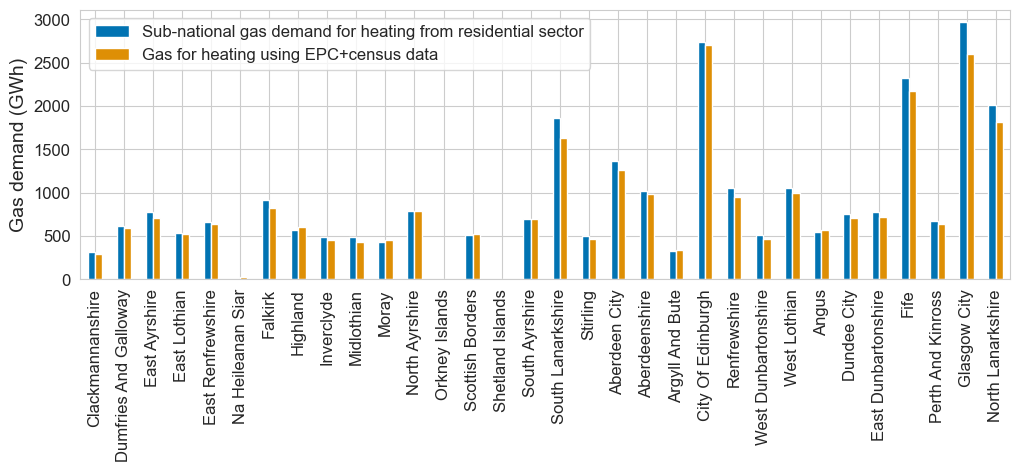

In [10]:
fig, ax = plt.subplots(figsize=figsize)
gas_validation_df.plot.bar(ax=ax)
handles, labels =  ax.get_legend_handles_labels()
labels = ['Sub-national gas demand for heating from residential sector', 'Gas for heating using EPC+census data']
ax.legend(labels=labels, handles=handles)
ax.set_ylabel("Gas demand (GWh)")

In [11]:
## Calculating average error

org_col = "Sub-national gas demand for heating from residential sector (GWh)"
compared_col = f"Total heat demand before energy efficiency measures from gas boilers {year} (GWh)"
non_zero_gas_validation_df = gas_validation_df.loc[gas_validation_df[org_col]>0].copy()
((non_zero_gas_validation_df[compared_col]-non_zero_gas_validation_df[org_col])/non_zero_gas_validation_df[org_col]).mean()

-0.047225099013152375

# Share of heating fuel in the total demand

In [12]:
heating_systems = [enums.heating_systems.GASBOILER.value, enums.heating_systems.OILBOILER.value, enums.heating_systems.RESISTANCE.value, enums.heating_systems.SOLIDFUELBOILER.value]
heating_fuels = [enums.heating_fuels.NATURALGAS.name, enums.heating_fuels.OIL.name, enums.heating_fuels.ELECTRICITY.name, enums.heating_fuels.SOLIDFUEL.name]

results_dict = {}
for ii, heating_system in enumerate(heating_systems):
  temp_cols = [x for x in full_results_df.columns if heating_system in x and "Total heat demand before energy efficiency measures of" in x]
  total_demand = full_results_df[temp_cols].sum(axis=1).sum()/1000000
  results_dict[heating_fuels[ii]] = total_demand

heating_demand_by_heating_fuel = (pd.DataFrame().from_dict(results_dict, orient="index")/1000)
heating_demand_by_heating_fuel.columns = ["Heat supplied (TWh)"]
heating_demand_by_heating_fuel

,Heat supplied (TWh)
NATURALGAS,47.488841
OIL,6.994914
ELECTRICITY,6.731186
SOLIDFUEL,1.113087


Text(0, 0.5, 'Heat supplied (TWh)')

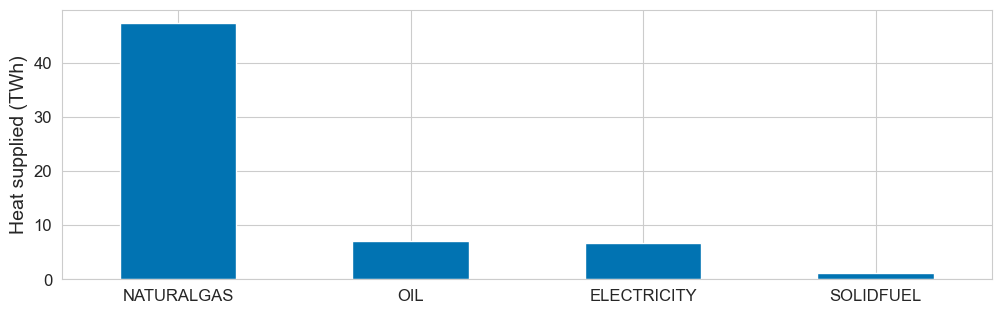

In [13]:
fig, ax = plt.subplots(figsize=figsize)
heating_demand_by_heating_fuel.plot.bar(rot=0, ax=ax)
ax.legend().remove()
ax.set_ylabel("Heat supplied (TWh)")

In [21]:
# Share of gas
org_cols = heating_fuels
compared_col = enums.heating_fuels.NATURALGAS.name
heating_demand_by_heating_fuel.loc[compared_col]/heating_demand_by_heating_fuel.loc[org_cols].sum()

Heat supplied (TWh)    0.761918
dtype: float64

# Heating demand from different dwelling categories

<AxesSubplot: xlabel='Average annual heat demand before energy efficiency measures (kWh)', ylabel='Dwelling category'>

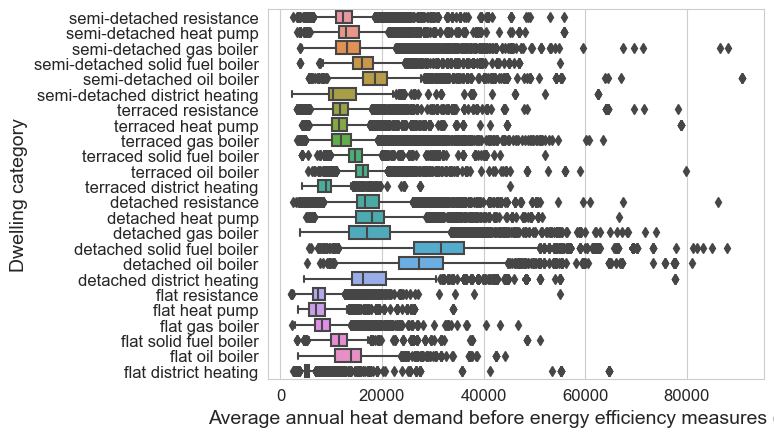

In [22]:
tidy_df = create_tidy_df(full_results_df)
sns.boxplot(data=tidy_df, y ='Dwelling category', x="Average annual heat demand before energy efficiency measures (kWh)")

In [23]:
def create_map(df, target, fig, ax, cmap=None, vmin=0, vmax=15):
    
    map_df = gpd.read_file(path_map_scotland)
    map_df.crs = {'init': 'epsg:4326'}
    
    map_df = pd.merge(map_df, df[[schema.finalCensusSchema.lsoa , target]], left_on='DataZone', right_on=schema.finalCensusSchema.lsoa, how="left")
    map_df = map_df.dropna(subset=[target])
    # create figure and axes for Matplotlib
    vmin=vmin
    vmax=vmax

    ax.axis('off')
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    
    if cmap==None:
        cmap='Blues'
        
    map_df.plot(column=target, cmap=cmap, linewidth=0.001, ax=ax,  edgecolor='black', vmin=vmin, vmax=vmax, legend=False, aspect=1) #,

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    
    plt.close()
    return cbar

In [24]:
to_plot_df = full_results_df.reset_index().copy()

fig, axs = plt.subplots(1, 2, figsize=(figsize[0],round(figsize[1])) )
plt.subplots_adjust(wspace=-0.2, hspace=0)

ax= axs[0]
target = "Total heat demand before energy efficiency measures 2011 (kWh)"
to_plot_df[target] = to_plot_df[target]/1000000

cmap_1 = 'magma_r'
cbar = create_map(to_plot_df[[schema.finalCensusSchema.lsoa, target]], target, fig, ax, cmap=cmap_1, vmin=0, vmax=15)
cbar.remove()
ax.set_title("Annual heat demand before\n energy efficiency measures by LSOA", fontsize= font_size+2)

ax= axs[1]
target = "Total heat demand after energy efficiency measures 2011 (kWh)"
to_plot_df[target] = to_plot_df[target]/1000000
cmap_1 = 'magma_r'
cbar = create_map(to_plot_df[[schema.finalCensusSchema.lsoa, target]], target, fig, ax, cmap=cmap_1, vmin=0, vmax=15)
ax.set_title("Annual heat demand after\n energy efficiency measures by LSOA", fontsize= font_size+2)

cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Annual heat demand [GWh]', rotation=270)

# fig.savefig(path_save_paper+os.path.sep+"figure_7."+fig_format, bbox_inches='tight', format=fig_format, dpi=dpi)

c:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\code\demand-estimation\demand-estimation\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\sceac10\AppData\Local\Temp\ipykernel_15276\3599353567.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)
c:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\code\demand-estimation\demand-estimation\lib\s

Text(0, 0.5, 'Annual heat demand [GWh]')

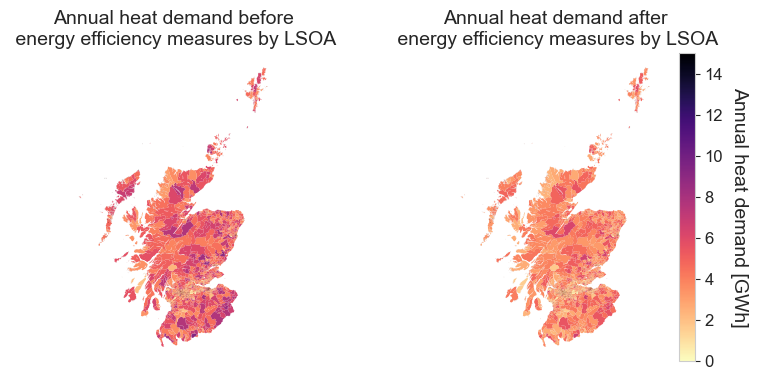

In [25]:
fig

In [26]:
to_plot_df = full_results_df.reset_index().copy()

fig, axs = plt.subplots(1, 2, figsize=(figsize[0],round(figsize[1])) )
plt.subplots_adjust(wspace=-0.2, hspace=0)

ax= axs[0]
target = "Total heat demand before energy efficiency measures 2018 (kWh)"
to_plot_df[target] = to_plot_df[target]/1000000

cmap_1 = 'magma_r'
cbar = create_map(to_plot_df[[schema.finalCensusSchema.lsoa, target]], target, fig, ax, cmap=cmap_1, vmin=0, vmax=15)
cbar.remove()
ax.set_title("Annual heat demand before\n energy efficiency measures by LSOA", fontsize= font_size+2)

ax= axs[1]
target = "Total heat demand after energy efficiency measures 2018 (kWh)"
to_plot_df[target] = to_plot_df[target]/1000000
cmap_1 = 'magma_r'
cbar = create_map(to_plot_df[[schema.finalCensusSchema.lsoa, target]], target, fig, ax, cmap=cmap_1, vmin=0, vmax=15)
ax.set_title("Annual heat demand after\n energy efficiency measures by LSOA", fontsize= font_size+2)

cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Annual heat demand [GWh]', rotation=270)

# fig.savefig(path_save_paper+os.path.sep+"figure_7."+fig_format, bbox_inches='tight', format=fig_format, dpi=dpi)

c:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\code\demand-estimation\demand-estimation\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\sceac10\AppData\Local\Temp\ipykernel_15276\3599353567.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)
c:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\code\demand-estimation\demand-estimation\lib\s

Text(0, 0.5, 'Annual heat demand [GWh]')

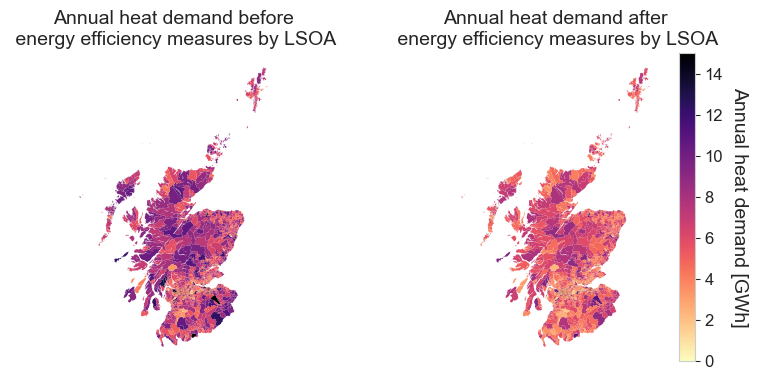

In [27]:
fig